<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Preprocess-10X" data-toc-modified-id="Preprocess-10X-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocess 10X</a></span></li><li><span><a href="#Load-10X" data-toc-modified-id="Load-10X-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load 10X</a></span></li><li><span><a href="#Single-Cell-Aggregate" data-toc-modified-id="Single-Cell-Aggregate-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Single Cell Aggregate</a></span></li></ul></li><li><span><a href="#Main" data-toc-modified-id="Main-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Main</a></span><ul class="toc-item"><li><span><a href="#Obtain-UMAP-data" data-toc-modified-id="Obtain-UMAP-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Obtain UMAP data</a></span></li><li><span><a href="#Calculate-kmeans-clusters" data-toc-modified-id="Calculate-kmeans-clusters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Calculate kmeans clusters</a></span></li><li><span><a href="#Plot-clusters" data-toc-modified-id="Plot-clusters-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Plot clusters</a></span></li></ul></li></ul></div>

# Import

In [1]:
# !pip install phate scprep umap-learn tasklogger magic-impute louvain seaborn scanpy
# !pip install git+https://github.com/jacoblevine/phenograph.git
# !pip install jupyter_contrib_nbextensions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
import sklearn.cluster
import sklearn.manifold

import scprep
import os
import tasklogger
import phate
import umap

import graphtools as gt
import magic
import phenograph
import louvain

from sklearn.decomposition import PCA

c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.


# Functions

## Preprocess 10X

In [3]:
def preprocess_10X(data, name='10X-project', percent_mt=20, max_features=5000, min_features=200):
    """This function takes a data-frame (genes x cells), 
    creates a Scprep object with it and filters the object for default tags such as  
    Min and max nFeature_RNA and % of MT

    Parameters:
    @param data data-frame
    @param percent_mt integer [0-100]
    @param max_features integer [0-Inf]
    @param min_features integer [0-Inf]
    
    Returns:
    @return Preprocessed Dataframe
    """
    #Remove empty cells and empty genes
    data = scprep.filter.filter_empty_cells(data)
    data = scprep.filter.filter_empty_genes(data)
    
    #Remove elements based on mythocondrial percentage
    mt_genes = scprep.select.get_gene_set(data, starts_with=["MT-", "mt-"])
    data = scprep.filter.filter_gene_set_expression(data=data, genes=mt_genes, percentile=100-percent_mt, keep_cells='below')
    
    #Remove elements based on number of cell and number of features
    data = scprep.filter.filter_library_size(data=data, cutoff=(min_features, max_features), keep_cells='between')
    data = scprep.filter.filter_rare_genes(data=data, cutoff=0, min_cells=3)

    return data

## Load 10X

In [4]:
def load_10X(dir_path, name='10X-project',percent_mt=20, max_features=5000, min_features=200):
    """This function takes the path to a 10X output folder and instanciates the Scprep object
    
    Parameters:
    @param file string (path to file)
    @param percent_mt integer [0-100]
    @param max_features integer [0-Inf]
    @param min_features integer [0-Inf]
    
    Returns:
    @return Preprocessed DataFrame
    """
    data = scprep.io.load_10X(dir_path, sparse=True, gene_labels='both')
    return preprocess_10X(data=data, percent_mt=percent_mt, max_features=max_features, min_features=min_features)

## Single Cell Aggregate

In [14]:
def sc_aggregate(metadata, cluster_param, target_param, order_by):
    """ Aggregate clusters of celltypes and extract proportion of a group
     
     
    @param metadata Target metadata dataframe
    @param cluster_param Str parameter identifying clusters
    @param target_param Str Name of the metadata feature to aggregate
    @param order_by List name of the metadata feature to order by
    @return DataFrame with different_columns of percentages
    @return Plot of percentages
    """
    keys = metadata[target_param].value_counts().keys()
    values = metadata[target_param].value_counts()
    print(values)
    perc_keys = [x+'_perc' for x in keys]
    df=pd.DataFrame(columns=perc_keys)
    df['tot_value'] = 0

    for c in sorted(metadata[cluster_param].unique()):
        #Get subset cluster data
        subset = metadata[metadata[cluster_param]==c]
        
        #Get total values 
        subset_val=subset[target_param].value_counts().to_dict()
#         print(subset_val)
        tot_value = subset[target_param].value_counts().sum()

        [subset_val.setdefault(k, 0) for k in keys]
        return_values = [round(subset_val[p]/tot_value*100,2)for p in subset_val]
        
        return_values.append(tot_value)

        df.loc[c] = return_values
      
    if isinstance(order_by, list):
        df = df.sort_values(by=[o+'_perc' for o in order_by], ascending=False)
    else:
        df = df.sort_values(by=order_by+'_perc', ascending=False)
        
    axis = df[[x+'_perc' for x in keys]].plot(kind="bar", stacked=True)
#     fig = axis.get_fig ure()
    
    return df, axis

# Main

In [6]:
data = scprep.io.load_csv("../data/moein_data/moein.data.csv", cell_axis = "column")
metadata = scprep.io.load_csv("../data/moein_data/moein.meta_data.csv")

c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\scprep\sanitize.py:53: RuntimeWarning: Data is not numeric. Many scprep functions will not work.
  RuntimeWarning,


In [7]:
data_phate = phate.PHATE().fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 13592 observations and 3897 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.91 seconds.
    Calculating KNN search...
    Calculated KNN search in 60.55 seconds.
    Calculating affinities...
    Calculated affinities in 39.17 seconds.
  Calculated graph and diffusion operator in 109.99 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 7.96 seconds.
    Calculating KMeans...
    Calculated KMeans in 38.03 seconds.
  Calculated landmark operator in 48.65 seconds.
  Calculating optimal t...
    Automatically selected t = 7
  Calculated optimal t in 7.20 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.44 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 9.73 seconds.
Calculated PHATE in 177.03 seconds.


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

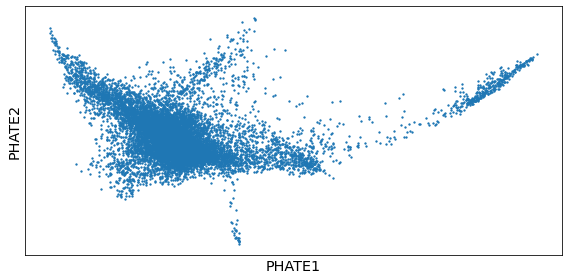

In [8]:
scprep.plot.scatter2d(data_phate, figsize=(8,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

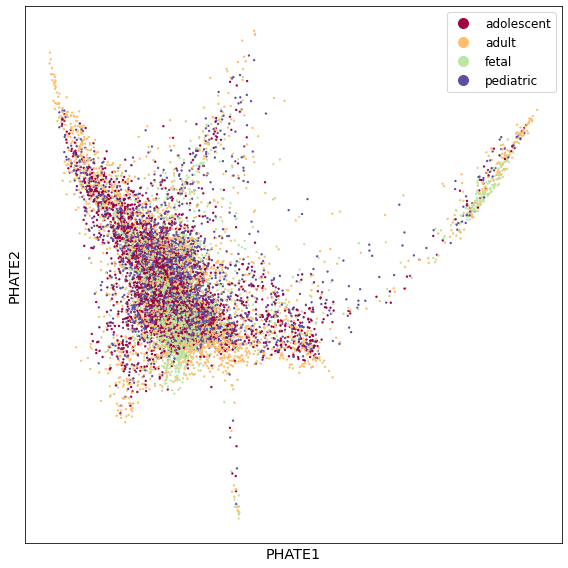

In [9]:
scprep.plot.scatter2d(data_phate, c=metadata["age"],figsize=(8,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

## Obtain UMAP data

In [29]:
#Obtain UMAP data
with tasklogger.log_task("UMAP"):
    data_umap = umap.UMAP(n_components=60).fit_transform(data)
    data_umap = pd.DataFrame(data_umap, index=data.index)

Calculating UMAP...
Calculated UMAP in 50.22 seconds.


## Calculate kmeans clusters

In [30]:
kmeans_clusters = sklearn.cluster.KMeans().fit_predict(data_umap)

## Plot clusters

<AxesSubplot:title={'center':'Clusters according to umap'}, xlabel='0', ylabel='1'>

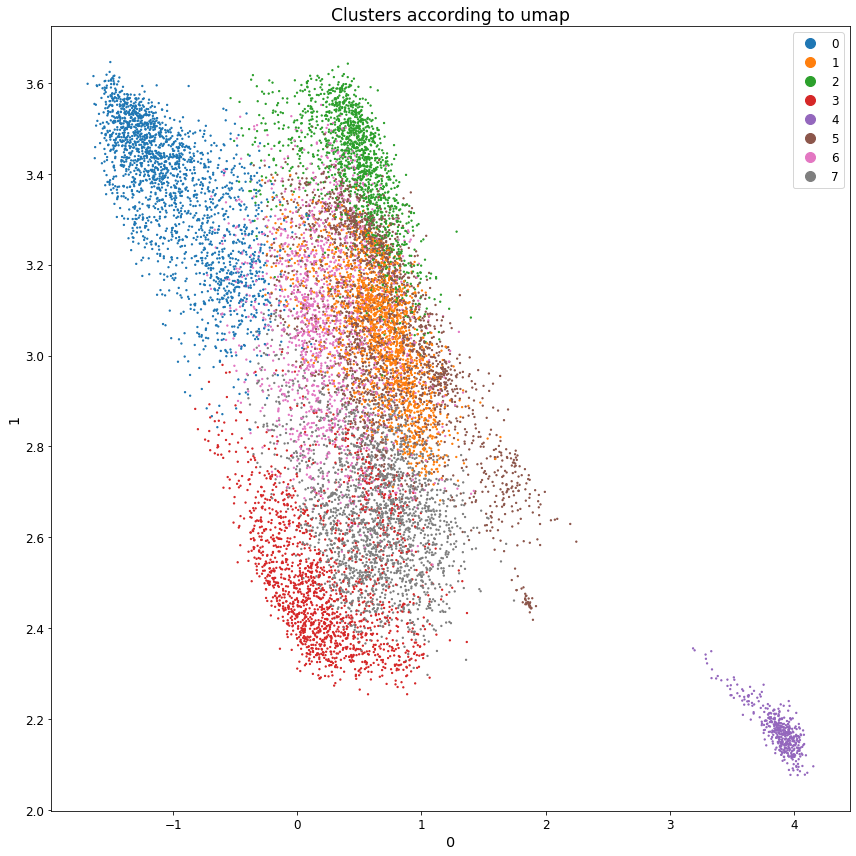

In [34]:
# scprep.plot.scatter2d(data_umap, c=metadata['age'],figsize=(12, 12),  title="Clusters according to umap")
scprep.plot.scatter2d(data_umap, c=kmeans_clusters,figsize=(12, 12),  title="Clusters according to umap")

In [10]:
metadata

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.6,seurat_clusters,age,S.Score,G2M.Score,Phase,integrated_snn_res.0.4
TCGCGAGGTTTAGGAA_1,HP773,1034.000000,650,3.288201,3.0,5,pediatric,-0.023260,-0.018602,G1,5
ACCTTTATCGTGACAT_1,HP773,2673.000000,1391,3.179948,4.0,0,pediatric,-0.051620,0.117481,G2M,0
CGGAGCTTCCGCATCT_1,HP773,927.000000,610,1.402373,3.0,0,pediatric,-0.037142,-0.079287,G1,0
CGCTGGAGTCGTTGTA_1,HP773,1820.000000,1034,3.241758,3.0,0,pediatric,0.005744,0.011691,G2M,0
GTGTGCGAGCGGCTTC_1,HP773,617.000000,365,3.727715,2.0,6,pediatric,-0.009725,-0.019488,G1,6
...,...,...,...,...,...,...,...,...,...,...,...
CTGCCTACAAGCTGAG_12,HF588,804.302460,337,1.001472,0.0,2,fetal,0.105172,-0.052438,S,2
TCGCGAGGTTGCTCCT_12,HF588,772.912931,310,1.519034,0.0,2,fetal,-0.004290,-0.050681,G1,2
AGAGCTTTCACCCGAG_12,HF588,930.952502,446,1.893067,2.0,0,fetal,-0.032441,-0.032703,G1,0
CTCGAAAAGATCGGGT_12,HF588,882.212233,393,2.471061,1.0,2,fetal,-0.018380,0.063663,G2M,2


pediatric     3434
adolescent    3411
fetal         3394
adult         3353
Name: age, dtype: int64


,pediatric_perc,adolescent_perc,fetal_perc,adult_perc,tot_value
1,37.57,28.83,25.91,7.69,2574.0
3,33.96,30.49,24.62,10.92,1584.0
5,32.16,28.87,23.92,15.05,485.0
0,32.46,30.39,20.55,16.61,5811.0
4,43.96,29.18,19.54,7.33,819.0
6,43.28,34.47,16.14,6.11,409.0
8,51.16,20.93,13.95,13.95,43.0
2,90.63,5.20,2.36,1.82,1867.0


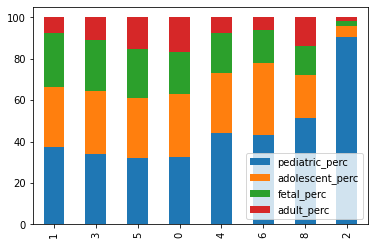

In [15]:
df, axis = sc_aggregate(metadata=metadata, 
                        cluster_param ='seurat_clusters', 
                        target_param = 'age', 
                        order_by = ['fetal'])

df